In [5]:
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from numpy import zeros


# load cifar training images
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X

# pick a batch of random real samples to train the GAN
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    # normal
    model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # minibatch discrimination
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same', kernel_initializer=init))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            
			X_real, y_real = generate_real_samples(dataset, half_batch)
			
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

    
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

            

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            
			y_gan = ones((n_batch, 1))

			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator_MINI_2epochs.h5')



# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)


2/2 [==============================] - 0s 168ms/step
Epoch>1, Batch 1/390, d1=0.688, d2=0.792 g=0.750
2/2 [==============================] - 1s 270ms/step
Epoch>1, Batch 2/390, d1=0.093, d2=0.850 g=0.873
2/2 [==============================] - 0s 168ms/step
Epoch>1, Batch 3/390, d1=0.007, d2=0.627 g=2.890
2/2 [==============================] - 0s 166ms/step
Epoch>1, Batch 4/390, d1=0.739, d2=0.398 g=1.218
2/2 [==============================] - 1s 269ms/step
Epoch>1, Batch 5/390, d1=0.172, d2=0.402 g=1.330
2/2 [==============================] - 0s 178ms/step
Epoch>1, Batch 6/390, d1=0.024, d2=0.274 g=1.873
2/2 [==============================] - 0s 169ms/step
Epoch>1, Batch 7/390, d1=0.000, d2=0.129 g=2.726
2/2 [==============================] - 1s 274ms/step
Epoch>1, Batch 8/390, d1=0.000, d2=0.062 g=3.591
2/2 [==============================] - 0s 169ms/step
Epoch>1, Batch 9/390, d1=0.000, d2=1.538 g=8.881
2/2 [==============================] - 0s 168ms/step
Epoch>1, Batch 10/390, d1=0.2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch>2, Batch 390/390, d1=0.746, d2=0.566 g=1.575


1/1 [==============================] - 0s 455ms/step


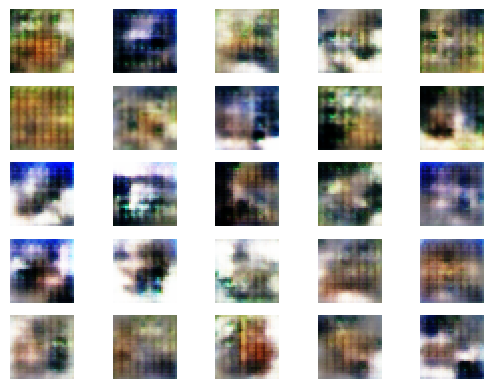

In [7]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt

# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('cifar_generator_MINI_2epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)